# Explore Magnetron2 Output


Let's take a look at what `magnetron2` actually returns.

In [17]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import numpy as np
import pandas as pd

datadir = "../data/" # directory with test data
res_dir = "./" # directory with results

## Generating a Simple Example

Let's first generate a simple example.

In [2]:
def twoexp(time, theta):
    """ The model method contains the actual function definition.
    Returns a numpy-array of size len(self.times)
    Parameters:
    event_time = start time of word relative to start time of time series
    scale = horizontal scale parameter to stretch/compress word
    skew = skewness parameter: how much faster is the rise than the decay?
    """
    t0 = theta[0]
    amp = theta[1]
    scale = theta[2]
    skew = theta[3]
    
    t = (time - t0) / scale
    y = np.zeros_like(t)
    y[t <= 0] = np.exp(t[t <= 0])
    y[t > 0] = np.exp(-t[t > 0] / skew)

    y = np.array(y)*amp

    return y


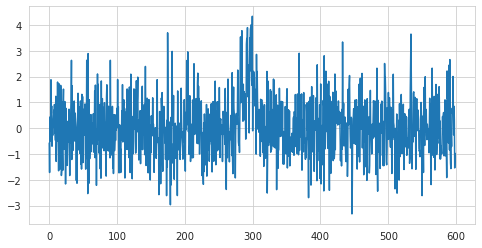

In [3]:
# Test data from Jason: lot's of substructure 
path = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/burst_profiles_M81R_Jan14-Mar17/data1/kenzie/M81_monitoring/bursts/numpy_profiles/"
data_test = np.load(path + "B3_Jan14_profile.npy") # Jansky (spectral flux density)

dt = 0.512 #5.12us resolution (except B2 on Jan 14 and B1,B2 on Feb21 which are all 40.96us resolution)
time = np.arange(0, dt*len(data_test), dt)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, data_test)

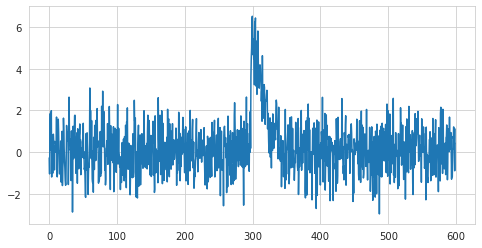

In [9]:
# Test data from Jason: "simple" burst 
path = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/burst_profiles_M81R_Jan14-Mar17/data1/kenzie/M81_monitoring/bursts/numpy_profiles/"
data_test = np.load(path + "B10_Jan14_profile.npy") # Jansky (spectral flux density)

dt = 0.512 #5.12us resolution (except B2 on Jan 14 and B1,B2 on Feb21 which are all 40.96us resolution)
time = np.arange(0, dt*len(data_test), dt)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, data_test)

In [24]:
# convert numpy array to dataframe
# adding time and flux error columns
import pandas as pd
df = pd.DataFrame(time, columns=['time'])
df['ytrue'] = data_test # flux values
df['yerr'] = 1.0e0 # flux errors 

# convert dataframe to .dat file 
df.to_csv('B10_Jan14_test2.dat', sep=" ", index=False)


<ErrorbarContainer object of 3 artists>

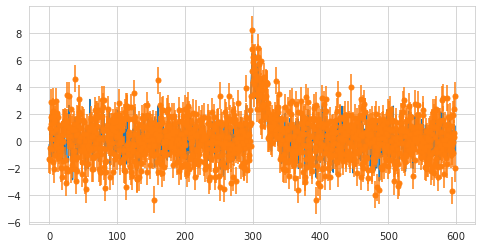

In [6]:
ytrue = df['ytrue']
time = df['time']
yerr = df['yerr']
# yerr = np.zeros_like(ytrue) + 1.0
yobs = np.random.normal(ytrue, yerr)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, ytrue)
ax.errorbar(time, yobs, yerr=yerr, fmt="o", markersize=5)

In [7]:
tseg = 1.0
dt = 0.01
t0 = 0.4
tau = 0.05
skew = 3.0
amp = 20.0

bkg = 3.0

theta = [t0, amp, tau, skew]

time = np.linspace(0, tseg, int(tseg/dt))
 
ytrue = twoexp(time, theta) + bkg

yerr = np.zeros_like(ytrue) + 1.0

yobs = np.random.normal(ytrue, yerr)


<ErrorbarContainer object of 3 artists>

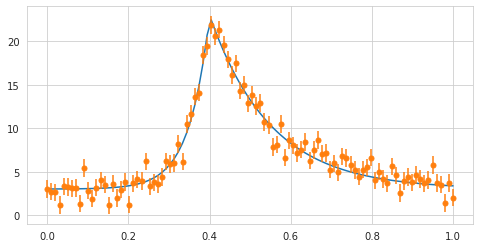

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, ytrue)
ax.errorbar(time, yobs, yerr=yerr, fmt="o", markersize=5)

In [9]:
np.savetxt(datadir + "gauss_test.dat", np.array([time, yobs, yerr]).T)

#### Loading the Results

Let's see what the posterior looks like:

In [19]:
# sample = np.loadtxt(datadir + "gauss_test_posterior_sample.txt", skiprows=2)
sample = np.loadtxt("../output_test/gauss_test/posterior_sample.txt", skiprows=2)
# sample = np.loadtxt("../output_test/B3_Jan14_test/posterior_sample.txt", skiprows=2)

In [20]:
# background parameter
bkg = sample[:,0]

# dimensionality of a single component
burst_dims =  sample[:,1]
burst_dims = list(set(burst_dims))[0]

# total number of model components permissible in the model
compmax = sample[:,2]
compmax = list(set(compmax))[0]

# hyper-parameter (mean) of the exponential distribution used
# as prior for the spike amplitudes
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_amplitude = sample[:,3]

# hyper-parameter (mean) for the exponential distribution used
# as prior for the spike rise time
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_risetime = sample[:,4]

# hyper-parameters for the lower and upper limits of the uniform
# distribution osed as a prior for the skew
hyper_lowerlimit_skew = sample[:,5]
hyper_upperlimit_skew = sample[:,6]

## distribution over number of model components
nbursts = sample[:, 7]
#print(nbursts)

# individual burst parameters for all 100 components
npos = sample[:,8:108] # peak position for all burst components
amp = sample[:,108:208] # amplitude for all burst components
scale = sample[:,208:308] # rise time for all burst components
skew = sample[:, 308:408] # skewness parameter for all burst components

# put all of the parameters together
pars_all = np.array([npos, amp, scale, skew]).T

# all of the mean models
ymodel_all = sample[:,-len(time):] # model flux

Text(0.5, 1.0, 'number of components')

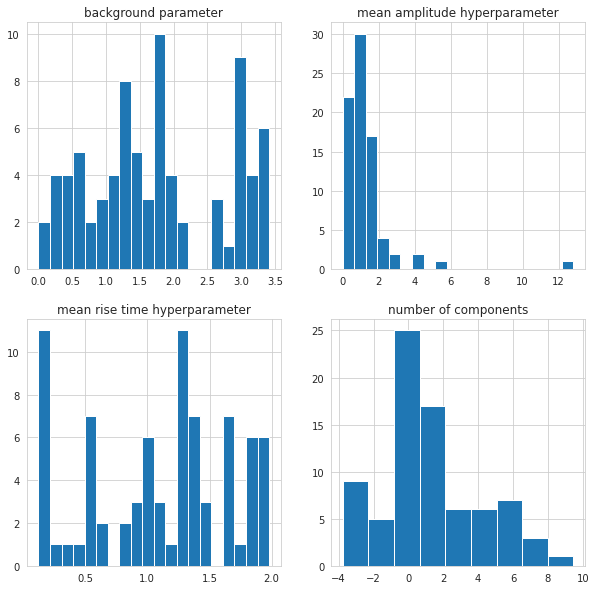

In [21]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

axes = np.hstack(axes)

axes[0].hist(bkg, bins=20)
axes[0].set_title("background parameter")

axes[1].hist(hyper_mean_amplitude, bins=20)
axes[1].set_title("mean amplitude hyperparameter")

axes[2].hist(hyper_mean_risetime, bins=20)
axes[2].set_title("mean rise time hyperparameter")

axes[3].hist(nbursts, bins=int(np.max(nbursts)))
axes[3].set_title("number of components")

NameError: name 'ytrue' is not defined

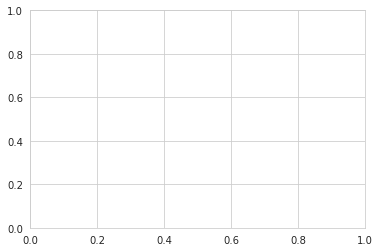

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time, ytrue)
ax.errorbar(time, yobs, yerr=yerr, fmt="o", markersize=5)
for i in range(15):
    ax.plot(time, ymodel_all[i,:])

### Loading and plotting the magnetar data

Doing the same with the sample magnetar burst (You need to run this first!)

In [13]:
data = pd.read_csv(datadir + "sample_data.txt", names=["time", "counts"], sep=" ")
# data = pd.read_csv("../output_test/gauss_test/sample.txt", names=["time", "counts"], sep=" ")

In [14]:
data

,time,counts
0,294.32077,6.0
1,294.32127,3.0
2,294.32177,1.0
3,294.32227,2.0
4,294.32277,2.0
...,...,...
185,294.41327,1.0
186,294.41377,3.0
187,294.41427,2.0
188,294.41477,3.0


<AxesSubplot:xlabel='time'>

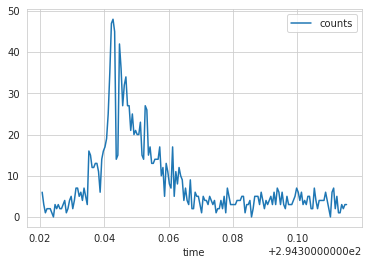

In [15]:
data.plot("time", "counts")

## Loading the Results

The results should be in `posterior_samples.txt` (need to run this)

In [16]:
sample = np.loadtxt("../output_test/gauss_test/posterior_sample.txt", skiprows=2)

In [19]:
# background parameter
bkg = sample[:,0]

# dimensionality of a single component
burst_dims =  sample[:,1]
burst_dims = list(set(burst_dims))[0]

# total number of model components permissible in the model
compmax = sample[:,2]
compmax = list(set(compmax))[0]

# hyper-parameter (mean) of the exponential distribution used
# as prior for the spike amplitudes
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_amplitude = sample[:,3]

# hyper-parameter (mean) for the exponential distribution used
# as prior for the spike rise time
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_risetime = sample[:,4]

# hyper-parameters for the lower and upper limits of the uniform
# distribution osed as a prior for the skew
hyper_lowerlimit_skew = sample[:,5]
hyper_upperlimit_skew = sample[:,6]

## distribution over number of model components
nbursts = sample[:, 7]
# print(nbursts)


Now we can get ou the parameters for each burst component:

In [20]:
npos = sample[:,8:108] # peak position for all burst components
amp = sample[:,108:208] # amplitude for all burst components
scale = sample[:,208:308] # rise time for all burst components
skew = sample[:, 308:408] # skewness parameter for all burst components

ymodel_all = sample[:,-len(data["time"]):] # model flux

In [21]:
npos = sample[:,8:108] # peak position for all burst components
amp = sample[:,108:208] # amplitude for all burst components
scale = sample[:,208:308] # rise time for all burst components
skew = sample[:, 308:408] # skewness parameter for all burst components

ymodel_all = sample[:,-len(data["time"]):] # model flux

pars_all = np.array([npos, amp, tau, skew], dtype=object).T

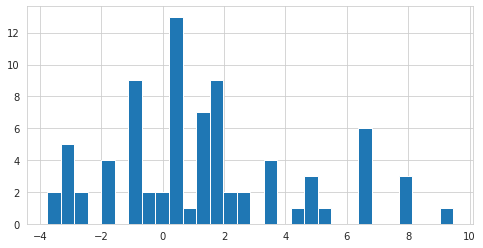

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.hist(nbursts, bins=30);

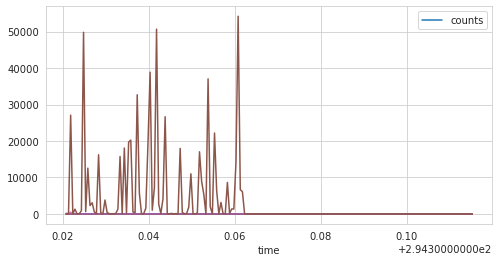

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

data.plot("time", "counts", ax=ax)

for i in range(15):
    ax.plot(data["time"], ymodel_all[i,:])

Let's write a function to plot posterior draws:

In [25]:
n = nbursts[0]
pars = pars_all[:,0,:]
pars = pars[:int(n),:]

NameError: name 'data' is not defined

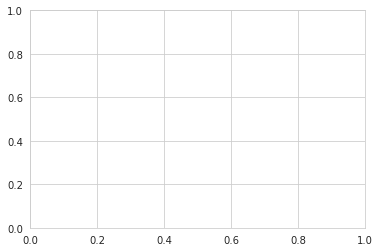

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

data.plot("time", "counts", ax=ax)

ymodel = np.zeros_like(data["time"])
for p in pars:
    ytest = twoexp(data["time"], p)
    ymodel += ytest
    ax.plot(data["time"], ytest)
    
ax.plot(data["time"], ymodel)

In [26]:
def generate_model(time, pars, nbursts):
    """
    Generate a model for a burst out of a set of rising and falling 
    exponentials, for a single (posterior) sample.
    
    The parameters need to be of form [[t0, amp, scale, skew], [...]] 
    for the individual burst components.
    
    Parameters
    ----------
    time : numpy.ndarray
        A 1D array with time stamps
        
    pars : numpy.ndarray
        A 2D array of shape (nbursts, 4), where nbursts is the number of 
        (non-zero) burst components, and the four columns contain the 
        peak time (t0), amplitude (amp), rise time (scale) and skewness (skew), 
        in that order.

    nbursts : int 
        The number of non-zero burst components in this sample
        
    Returns
    -------
    ymodel : numpy.ndarray
        A list of model fluxes corresponding to the arrival times.
    
    """
    
    ymodel = np.zeros_like(time)
    for p in pars:
        ytest = twoexp(time, p)
        ymodel += ytest

    return ymodel
    